In [1]:
from analysis import *

## Page Rank Over 1

In [3]:
df = pd.read_sql("""
        SELECT
            page_visits.visit_id,
            page_visits.pagerank,
            page_visits.stimuli_id,
            participants.participant_id,
            participants.xp_level,
            participants.programming_xp,
            participants.python_xp
        FROM page_visits
        LEFT JOIN participants
        ON page_visits.participant_id = participants.participant_id;
    """, con = credentials)

In [4]:
df['rank_over_1'] = df.apply (lambda row: row['pagerank'] > 1, axis=1)
df['rank_over_3'] = df.apply (lambda row: row['pagerank'] > 3, axis=1)

In [5]:
df

,visit_id,pagerank,stimuli_id,participant_id,xp_level,programming_xp,python_xp,rank_over_1,rank_over_3
0,562,1,23,1,Expert,5.0,1.50,False,False
1,563,1,6,1,Expert,5.0,1.50,False,False
2,564,2,6,1,Expert,5.0,1.50,True,False
3,565,1,21,1,Expert,5.0,1.50,False,False
4,566,1,21,1,Expert,5.0,1.50,False,False
...,...,...,...,...,...,...,...,...,...
1196,4203,1,3,40,True Novice,1.0,0.25,False,False
1197,4204,1,5,40,True Novice,1.0,0.25,False,False
1198,4205,2,5,40,True Novice,1.0,0.25,True,False
1199,4206,1,23,40,True Novice,1.0,0.25,False,False


In [6]:
chi_test(df, 'xp_level', df['rank_over_1'])

rank_over_1,False,True
xp_level,,
Expert,265,374
Python Novice,139,140
True Novice,148,135


,name,value
0,chi-square statistic,11.434154
1,p-value,0.003289
2,degrees of freedom,2.000000


Pearson residuals


rank_over_1,False,True
xp_level,,
Expert,-1.674409,1.544219
Python Novice,0.950800,-0.876872
True Novice,1.571991,-1.449764


Standardized residuals


rank_over_1,False,True
xp_level,,
Expert,-3.329769,3.329769
Python Novice,1.476196,-1.476196
True Novice,2.445960,-2.445960


Chi2 Contributions


rank_over_1,False,True
xp_level,,
Expert,2.803646,2.384611
Python Novice,0.904020,0.768904
True Novice,2.471156,2.101816


In [7]:
contingency_table = pd.crosstab(df['rank_over_1'],df['xp_level'])
display(contingency_table)

pd.crosstab(df['rank_over_1'],df['xp_level']).apply(lambda r:r/r.sum(),axis=0)

xp_level,Expert,Python Novice,True Novice
rank_over_1,,,
False,265,139,148
True,374,140,135


xp_level,Expert,Python Novice,True Novice
rank_over_1,,,
False,0.41471,0.498208,0.522968
True,0.58529,0.501792,0.477032


In [8]:
#This table helps us to calculate the SE.
prop = df.groupby("xp_level")["rank_over_1"].agg([lambda z: np.mean(z), "size"])
prop.columns = ['proportions_rank_over_1','total_counts']
prop.head()

,proportions_rank_over_1,total_counts
xp_level,,
Expert,0.585290,639
Python Novice,0.501792,279
True Novice,0.477032,283


In [9]:
#Calculating standard error
total_proportion_rank_over_1 = df.rank_over_1.mean()

variance = total_proportion_rank_over_1 * (1 - total_proportion_rank_over_1)
standard_error = np.sqrt(variance * (1 / prop.total_counts['Expert'] + 1 / prop.total_counts['Python Novice'] + 1 / prop.total_counts['True Novice']))
print("Sample Standard Error",standard_error)

Sample Standard Error 0.04643841263503243


## Rank Over 3

In [12]:
chi_test(df, 'xp_level', df['rank_over_3'])

rank_over_3,False,True
xp_level,,
Expert,483,156
Python Novice,224,55
True Novice,239,44


,name,value
0,chi-square statistic,9.718905
1,p-value,0.007755
2,degrees of freedom,2.000000


Pearson residuals


rank_over_3,False,True
xp_level,,
Expert,-0.905979,1.744992
Python Novice,0.285890,-0.550648
True Novice,1.077505,-2.075366


Standardized residuals


rank_over_3,False,True
xp_level,,
Expert,-2.874239,2.874239
Python Novice,0.708119,-0.708119
True Novice,2.674674,-2.674674


Chi2 Contributions


rank_over_3,False,True
xp_level,,
Expert,0.820798,3.044999
Python Novice,0.081733,0.303213
True Novice,1.161017,4.307146


## Number of Page Visits Per Session

In [13]:
# Label XP Level
def label_xp_level(row):
    if row['participant_id'] in experts :
        return 'Expert'
    if row['participant_id'] in middle:
        return 'Python Novice'
    if row['participant_id'] in novices:
        return 'True Novice'
    return 'No Group'

In [14]:
cur.execute("SELECT stimuli_id, error_type FROM stimuli")
stimuli = cur.fetchall()

stimuli_to_error = ['' for i in range(len(stimuli))]

for stimuli_id, error_type in stimuli:
    stimuli_to_error[stimuli_id] = error_type

def label_error_type(row):
    return stimuli_to_error[row['stimuli_id']]

#df.apply(lambda row: label_error_type(row), axis=1)
df['error_type'] = df.apply(lambda row: label_error_type(row), axis=1)
df['xp_level'] = df.apply(lambda row: label_group(row), axis=1)

In [15]:
# A session is represented by (p_id, s_id) tuple
sessions = df.groupby(['participant_id', 'stimuli_id']).size().to_frame('num_visits').reset_index()
# sessions = sessions.groupby(['participant_id'])[0].agg(['count']).reset_index()
sessions

,participant_id,stimuli_id,num_visits
0,1,0,9
1,1,6,2
2,1,10,2
3,1,15,1
4,1,21,5
...,...,...,...
328,39,24,4
329,39,27,3
330,40,3,2
331,40,5,2


In [16]:
# Gets number of sessions for each participant
num_sessions = sessions.groupby('participant_id')['stimuli_id'].agg(['nunique']).reset_index()['nunique']
sessions = sessions.groupby('participant_id')['num_visits'].agg(num_visits=('sum')).reset_index()
sessions['num_sessions'] = num_sessions
sessions['xp_level'] = sessions.apply(lambda row: label_xp_level(row), axis=1)

In [17]:
# Ratio of total number page visits over total number of sessions
# for every error type, xp_level pair
sessions['visits_to_sessions'] = sessions['num_visits'] / sessions['num_sessions']
sessions

,participant_id,num_visits,num_sessions,xp_level,visits_to_sessions
0,1,21,7,Expert,3.000000
1,2,25,7,Expert,3.571429
2,3,18,7,Expert,2.571429
3,4,17,7,Expert,2.428571
4,5,9,7,Python Novice,1.285714
5,6,13,7,Expert,1.857143
6,7,23,10,Expert,2.300000
7,8,14,7,Python Novice,2.000000
8,9,30,7,Expert,4.285714
9,10,22,7,Expert,3.142857


In [18]:
# Perform an ANOVA test using f_oneway from scipy.stats
# Categorical variable: xp_level
# Continuous variable: Number of page visits per session
fvalue, pvalue = stats.f_oneway(
                    sessions[sessions['xp_level'] == 'Expert'].visits_to_sessions,
                    sessions[sessions['xp_level'] == 'Python Novice'].visits_to_sessions,
                    sessions[sessions['xp_level'] == 'True Novice'].visits_to_sessions
                 )
print("ANOVA f-value:",fvalue)
print("ANOVA p-value:",pvalue)

ANOVA f-value: 0.5802721517510894
ANOVA p-value: 0.5647581713750338


SPEARMAN'S R FOR PROGRAMMING XP VS. Average Number of Page Visits per Session: -0.0640817816142234
P-VALUE (TWO-TAILED): 0.694436714014778
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
SPEARMAN'S R FOR PYTHON XP VS. Average Number of Page Visits per Session: 0.1341624696019399
P-VALUE (TWO-TAILED): 0.4091715198302025
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
SPEARMAN'S R FOR PROFESSIONAL XP VS. Average Number of Page Visits per Session: 0.2558830174574136
P-VALUE (TWO-TAILED): 0.27619048120706746


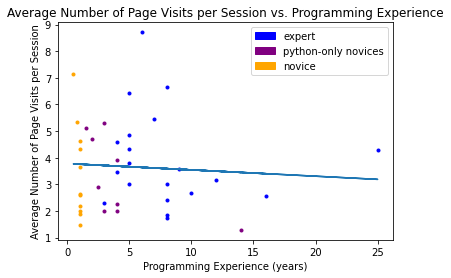

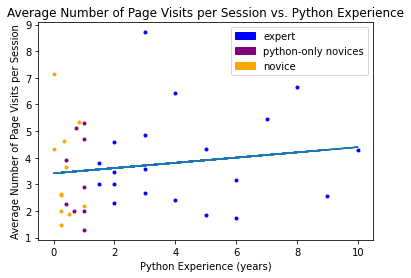

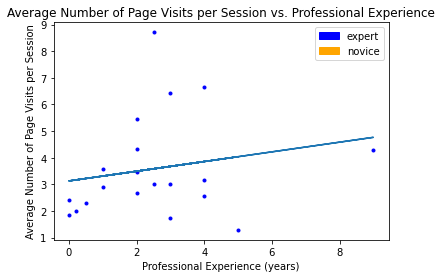

In [19]:
# Average number of page visits per session by experience level
avg_num_page_visits_per_session = [0 for p_id in range(40)]

for p_id in range(1, num_participants + 1):
    avg_num_page_visits_per_session[p_id - 1] = sessions[sessions['participant_id'] == p_id]['visits_to_sessions']

get_xp_correlation(avg_num_page_visits_per_session, "Average Number of Page Visits per Session")

# Number of Queries per Session

In [20]:
# A session is represented by (p_id, s_id) tuple
queries = df = pd.read_sql("""
            SELECT
                queries.query_id,
                queries.stimuli_id,
                participants.participant_id,
                participants.xp_level,
                participants.programming_xp,
                participants.python_xp
            FROM queries
            LEFT JOIN participants
            ON queries.participant_id = participants.participant_id;
        """, con = credentials)
queries = df.groupby(['participant_id', 'stimuli_id']).size().to_frame('num_queries').reset_index()
queries

,participant_id,stimuli_id,num_queries
0,1,0,5
1,1,6,1
2,1,10,2
3,1,15,1
4,1,21,4
...,...,...,...
328,39,24,2
329,39,27,3
330,40,3,2
331,40,5,3


In [21]:
# Gets number of sessions for each participant
queries = queries.groupby('participant_id')['num_queries'].agg(num_queries=('sum')).reset_index()
queries['num_sessions'] = num_sessions
queries['xp_level'] = sessions.apply(lambda row: label_xp_level(row), axis=1)

In [22]:
# Ratio of total number page visits over total number of sessions
# for every error type, xp_level pair
queries['queries_to_sessions'] = queries['num_queries'] / queries['num_sessions']


In [23]:
# Perform an ANOVA test using f_oneway from scipy.stats
# Categorical variable: xp_level
# Continuous variable: Number of page visits per session
fvalue, pvalue = stats.f_oneway(
                    queries[queries['xp_level'] == 'Expert'].queries_to_sessions,
                    queries[queries['xp_level'] == 'Python Novice'].queries_to_sessions,
                    queries[queries['xp_level'] == 'True Novice'].queries_to_sessions
                 )
print("ANOVA f-value:",fvalue)
print("ANOVA p-value:",pvalue)

ANOVA f-value: 0.15882117222731054
ANOVA p-value: 0.8537274213804414


SPEARMAN'S R FOR PROGRAMMING XP VS. Average Number of Queries per Session: -0.1294366137547203
P-VALUE (TWO-TAILED): 0.42601613110022984
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
SPEARMAN'S R FOR PYTHON XP VS. Average Number of Queries per Session: -0.01770584867190355
P-VALUE (TWO-TAILED): 0.9136474087593887
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
SPEARMAN'S R FOR PROFESSIONAL XP VS. Average Number of Queries per Session: 0.3261259864593185
P-VALUE (TWO-TAILED): 0.16053213449995246


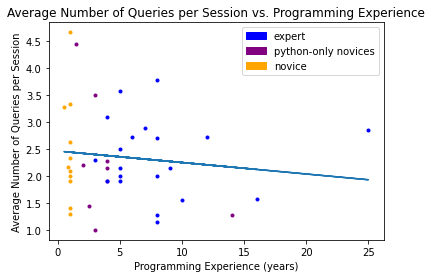

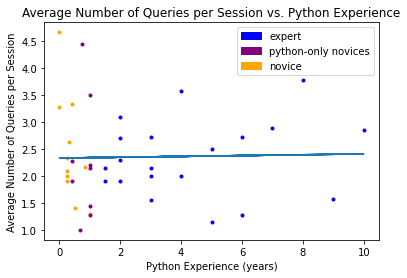

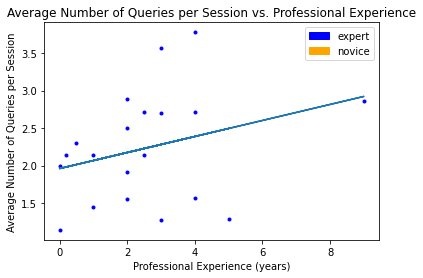

In [24]:
# Average number of page visits per query by experience level
avg_num_queries_per_session = [0 for p_id in range(40)]

for p_id in range(1, num_participants + 1):
    avg_num_queries_per_session[p_id - 1] = queries[queries['participant_id'] == p_id]['queries_to_sessions']

get_xp_correlation(avg_num_queries_per_session, "Average Number of Queries per Session")

# Number of Page Visits Per Query

In [25]:
query_visit_counts = pd.read_sql("""
                                 SELECT
                                 query_id,
                                 participant_id,
                                 stimuli_id,
                                 COUNT(*) AS num_page_visits
                                 FROM page_visits
                                 GROUP BY query_id""", con = credentials)


In [26]:
# Label error type
query_visit_counts['error_type'] = query_visit_counts.apply(lambda row: label_error_type(row), axis=1)


In [27]:
query_visit_counts['xp_level'] = query_visit_counts.apply(lambda row: label_xp_level(row), axis=1)

In [28]:
query_visit_counts.sort_values('num_page_visits')

,query_id,participant_id,stimuli_id,num_page_visits,error_type,xp_level
0,815,1,23,1,AttributeError,Expert
395,2900,26,11,1,TypeError,True Novice
392,2896,26,17,1,IndexError,True Novice
391,2895,26,5,1,TypeError,True Novice
388,2891,25,15,1,IndexError,True Novice
...,...,...,...,...,...,...
282,1140,18,2,8,SyntaxError,Expert
450,2964,29,11,8,TypeError,True Novice
243,1096,16,7,9,TypeError,Expert
167,1013,12,1,9,SyntaxError,Expert


In [29]:
# Perform an ANOVA test using f_oneway from scipy.stats
# Categorical variable: xp_level
# Continuous variable: Number of page visits per unique query
fvalue, pvalue = stats.f_oneway(
                    query_visit_counts[query_visit_counts['xp_level'] == 'Expert'].num_page_visits,
                    query_visit_counts[query_visit_counts['xp_level'] == 'Python Novice'].num_page_visits,
                    query_visit_counts[query_visit_counts['xp_level'] == 'True Novice'].num_page_visits
                 )
print("ANOVA f-value:",fvalue)
print("ANOVA p-value:",pvalue)

ANOVA f-value: 3.042684409824424
ANOVA p-value: 0.0483754009409446


In [30]:
# Check Assumptions: Normality
from statsmodels.formula.api import ols
model = ols('num_page_visits ~ C(xp_level)', data=query_visit_counts).fit()

stats.shapiro(model.resid) # Returns (W-test statistic, p-value)

ShapiroResult(statistic=0.7082334160804749, pvalue=2.2458539562749681e-32)

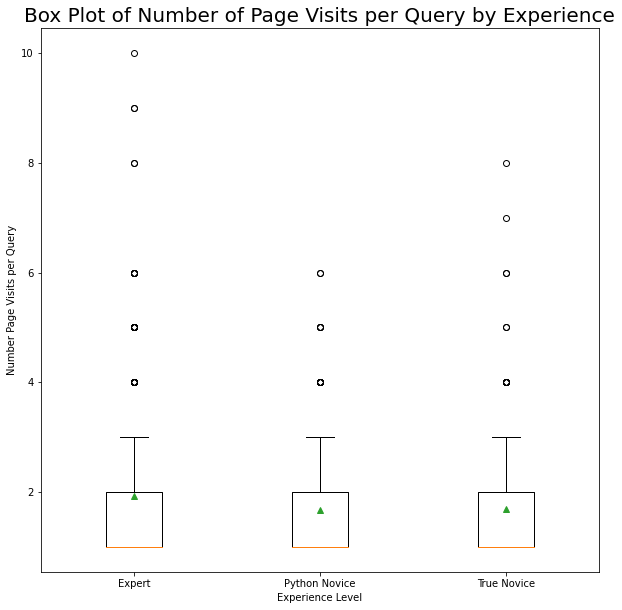

In [31]:
# Check Assumptions: Homogeneity of variance
# https://www.pythonfordatascience.org/anova-python/
stats.levene(query_visit_counts['num_page_visits'][query_visit_counts['xp_level'] == 'Expert'],
             query_visit_counts['num_page_visits'][query_visit_counts['xp_level'] == 'Python Novice'],
             query_visit_counts['num_page_visits'][query_visit_counts['xp_level'] == 'True Novice'])

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Number of Page Visits per Query by Experience", fontsize= 20)
ax.set

data = [query_visit_counts['num_page_visits'][query_visit_counts['xp_level'] == 'Expert'],
        query_visit_counts['num_page_visits'][query_visit_counts['xp_level'] == 'Python Novice'],
        query_visit_counts['num_page_visits'][query_visit_counts['xp_level'] == 'True Novice']]

ax.boxplot(data,
           labels= ['Expert', 'Python Novice', 'True Novice'],
           showmeans= True)

plt.xlabel("Experience Level")
plt.ylabel("Number Page Visits per Query")

plt.show()

SPEARMAN'S R FOR PROGRAMMING XP VS. Average Number of Page Visits per Query: 0.04123518253050016
P-VALUE (TWO-TAILED): 0.8005527605421005
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
SPEARMAN'S R FOR PYTHON XP VS. Average Number of Page Visits per Query: 0.3191122334248426
P-VALUE (TWO-TAILED): 0.04474315300501642
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
SPEARMAN'S R FOR PROFESSIONAL XP VS. Average Number of Page Visits per Query: 0.11905771770024604
P-VALUE (TWO-TAILED): 0.6171151528301118


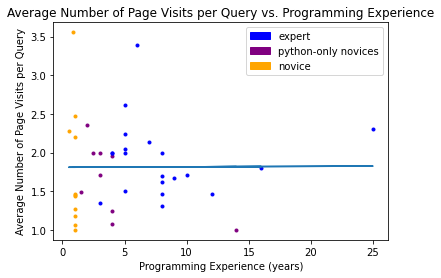

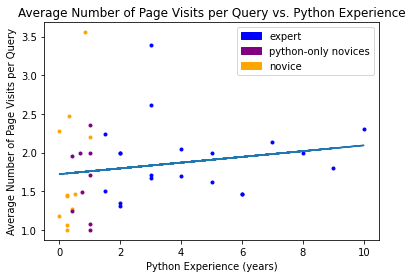

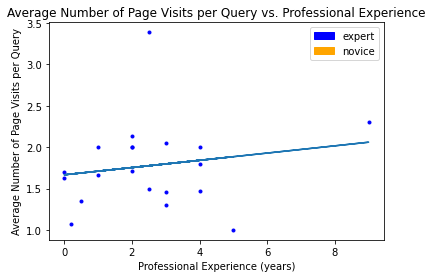

In [32]:
# Average number of page visits per query by experience level
avg_num_page_visits_per_query = [0 for p_id in range(40)]

for p_id in range(1, num_participants + 1):
    avg_num_page_visits_per_query[p_id - 1] = query_visit_counts[query_visit_counts['participant_id'] == p_id]['num_page_visits'].mean()

get_xp_correlation(avg_num_page_visits_per_query, "Average Number of Page Visits per Query")